In [156]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import bisect
from scipy import spatial

import inv_cdfs as icdf
import agents_network as anet
import utils

We start by creating $n$ agents which are in $\mathbb{R}^p$. These agents are split in two groups, some of them are labelled $y=1$ and others $y=2$.

In [157]:
npeers, p = 10, 2 # number of agents, dimension
nsamples = 10000
n1 = int(3*npeers/4)
n2 = npeers-n1
t, R = 2*np.pi*np.random.randn(n1,1), 2
r = R*(1.5 + .2*np.random.randn(n1,1)) # radius
X1 = np.hstack((np.cos(t)*r, np.sin(t)*r));
X = np.vstack((X1, np.random.randn(n2,2)))
y = np.vstack(( np.ones([n1,1]), 2*np.ones([n2,1]) ))


X = np.ones((npeers,2))

We plot the agents. Those in blue are labelled $y=1$ and in orange are labelled $y=2$.

(0.945, 1.0550000000000002, 0.945, 1.0550000000000002)

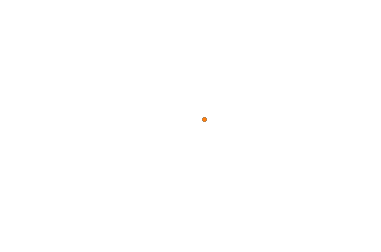

In [158]:
I = np.nonzero(y==1)[0]
J = np.nonzero(y==2)[0]
plt.plot(X[I,0], X[I,1], '.')
plt.plot(X[J,0], X[J,1], '.')
plt.axis('equal')
plt.axis('off')

The following function generate specific datas for each agent. Depending on their labelled and $\|x\|_2$, each agent received data from different distributions.

In [159]:
def create_data(x, y ,nsamples=1000):
    if y==1:
        data = np.random.poisson(np.linalg.norm(x), nsamples)
    elif y==2:
        #data = ss.expon.rvs(np.linalg.norm(x), size=nsamples)
        data = np.random.poisson(np.linalg.norm(x), nsamples)
        #data = ss.norm.rvs(np.linalg.norm(x), size=nsamples)
    else:
        print("choose y in {1,2}")
    return data

We define DATA to be list of data received by each agent. Then, we plot two examples :

In [160]:
DATA = [create_data(X[k], y[k], nsamples) for k in range(npeers)]

i, j = np.random.choice(I), np.random.choice(J)
print('i=', i, 'et j=', j)
print('data for an element of I : ', DATA[i][:10])
print('data for an element of J : ', DATA[j][:10])

i= 6 et j= 9
data for an element of I :  [0 2 2 2 2 3 2 5 0 1]
data for an element of J :  [2 0 1 0 0 2 1 1 1 1]


We build the similarity matrix.

In [161]:
def distmat(X, Z):
    return spatial.distance.cdist(X,Z)**2

def Similarities(X,sigma):
    similarities = np.exp( -distmat(X,X)/(2*sigma**2) )
    np.fill_diagonal(similarities, 0)
    return similarities

M = np.zeros((npeers,npeers))
for k in range(npeers):
    M[k,:] = (y[k]==y).flatten()
def Similarities_bis(X,sigma):
    a = np.tensordot(np.linalg.norm(X,axis=1),np.ones(npeers),0)
    b = np.tensordot(np.ones(npeers),np.linalg.norm(X,axis=1),0)
    similarities = np.exp( -abs(a-b)/(2*sigma**2) )
    np.fill_diagonal(similarities, 0)
    return similarities*M

We look the similarity matrix thanks to the functions defines above.

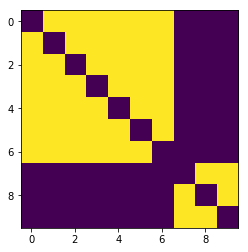

In [162]:
sigma = 0.1
W = Similarities(X,sigma)
W = Similarities_bis(X,sigma)
plt.imshow(W)

Now, we define two methods to calculate density functions from datas :

In [163]:
def methode_Noyau(data, K=ss.norm.pdf):
    nsamples = len(data)
    sigma = data.std()
    h = sigma/nsamples**(0.2) # thumb rule
    densite = lambda y : np.sum([K((y-x)/h) for x in data])/(nsamples*h)
    return densite

def methode_MC(data):
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob =  Nb_occurences/np.sum(Nb_occurences)
    return ensemble_des_valeurs, prob

We plot the density got from an agent labelled $y=1$.

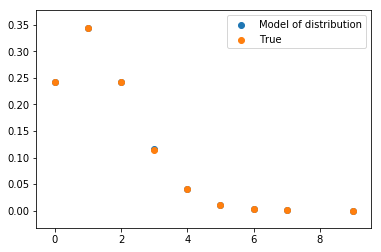

In [164]:
data = DATA[i]
ensemble_des_valeurs, prob = methode_MC(data)
plt.scatter(ensemble_des_valeurs, prob, label='Model of distribution')
plt.scatter(ensemble_des_valeurs, ss.poisson.pmf(ensemble_des_valeurs,np.linalg.norm(X[i])), label='True')
plt.legend()

We plot the density got from an agent labelled $y=2$.

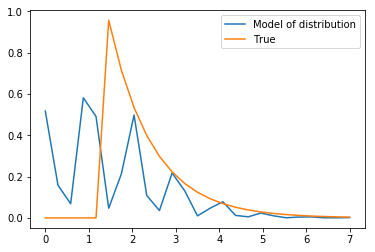

In [165]:
data = DATA[j]
densite = methode_Noyau(data)
tt = np.linspace(np.min(data), np.max(data), 25)
plt.plot(tt, [densite(t) for t in tt], label='Model of distribution')
plt.plot(tt, ss.expon.pdf(tt,np.linalg.norm(X[j])), label='True')
plt.legend()

Once we have the densities, we need the functions $g_s(v)$. Firstly, we define the cumulative empirical function $F$, and then $g$ represents its inverse. 

In [166]:
def F(data):
    nsamples = len(data)
    data_sorted = np.sort(data)
    return lambda t : bisect.bisect(data_sorted,t)/nsamples

def g(data):
    nsamples = len(data)
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob_cum = np.cumsum(Nb_occurences)/nsamples
    return prob_cum, ensemble_des_valeurs

For $u,v$ two neighbors, we plot $g_s(u)$ and $g_s(v)$ :

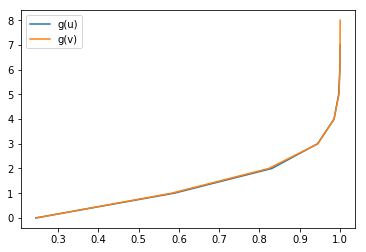

In [167]:
G = [g(data) for data in DATA]
u = np.random.randint(npeers)
v = np.argmax(W[u])

xx, yy = G[u]
plt.plot(xx, yy, label='g(u)')
xx, yy = G[v]
plt.plot(xx, yy, label='g(v)')
plt.legend()

We find that neighbor agents have very similar distributions. In conclusion, they can exchange information to better learn their models.

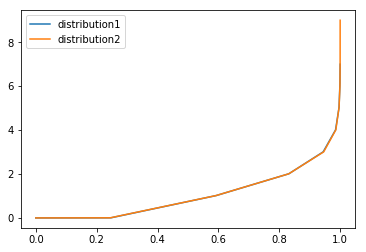

In [168]:
xx = np.linspace(0, 1, nsamples)
invcdfs = [icdf.InvCdf(nsamples, np.interp(xx, G[k][0], G[k][1])) for k in range(npeers)]

plt.plot(invcdfs[j].qs, invcdfs[j].invcdf, label='distribution1')
plt.plot(invcdfs[i].qs, invcdfs[i].invcdf, label='distribution2')
plt.legend()

# Stack agents in a list
agents = [anet.Agent(npeers, k, invcdfs[k]) for k in range(npeers)]

# Confidence of 1 in every model
C = np.ones(npeers)

No handles with labels found to put in legend.


Text(0.5,1,'Propagated cdfs')

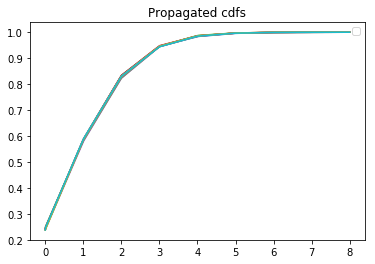

In [169]:
# Build network
network = anet.AgentNetwork(W, C, agents, mu=15)
# Run asynchronous gossip algorithm
network.iterate_async_gossip(1000)
# Update finale model for each agents
network.update_invcdf_models()
# On les stocke dans une list
invcdfs = [network.agents[k].invcdf_model for k in range(0, npeers)]
# Fill the cdf from those models for each agent
for invcdf in invcdfs:
    invcdf.fill_cdf(start=0, stop=8, nsamples_cdf=1000)
    
invcdfs = [network.agents[i].invcdf_model for i in range(0, npeers)]# Plot propagated cdfs
plt.figure()
for k in range(0, npeers):
    plt.plot(invcdfs[k].ts, invcdfs[k].cdf)#, label=k)
plt.legend()
plt.title("Propagated cdfs")

In [170]:
Previous_error, New_error = [], []

for k in range(npeers):
    tt = invcdfs[k].ts
    if y[k]==1:
        F = ss.poisson.cdf(tt, mu=np.linalg.norm(X[k]))
        #F = ss.norm.cdf(tt, loc=np.linalg.norm(X[k]))
    else : 
        #F = ss.expon.cdf(tt, loc=np.linalg.norm(X[k]))
        F = ss.poisson.cdf(tt, mu=np.linalg.norm(X[k]))
    Previous_error.append(np.linalg.norm(F-np.interp(tt,G[k][1],G[k][0]))) # ce qu'on a en entrée
    New_error.append(np.linalg.norm(F-invcdfs[k].cdf))

print('previous error :', np.mean(Previous_error), ', new error:', np.mean(New_error))
print('Diminution relative de l erreur:', (np.mean(Previous_error)-np.mean(New_error))/np.mean(New_error))

previous error : 2.8117881527926882 , new error: 2.8125511371736294
Diminution relative de l erreur: -0.00027127840303300846
